# Constant Acceleration and Noise

Generate 2d kinematic data with constant acceleration and noise. Adds noise to each measurement

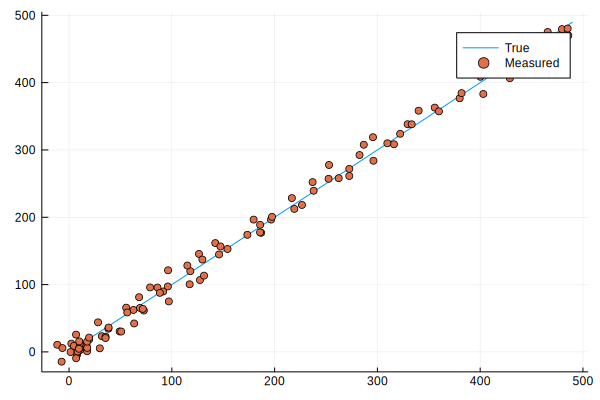

In [400]:
using Plots

#Initial Acceleration
ax = .1
ay = .1

#Initial Position
x0 = 0.0
y0 = 0.0

#Initial Velocity
vx0 = 0.0
vy0 = 0.0

#Measurement Arrays
x = [x0]
y = [y0]
vx = [vx0]
vy = [vy0]

measurements = 100
dt = 1

#Generate true gold set data based on kinematic equations 
for i in 2:measurements
    xi = x[i-1] + vx[i-1] * dt + ax * .5 * dt^2
    yi = y[i-1] + vy[i-1] * dt + ay * .5 * dt^2
    vxi = vx[i-1] + ax*dt
    vyi = vy[i-1] + ay*dt
    append!(x,xi)
    append!(y,yi)
    append!(vx,vxi)
    append!(vy,vyi)
end

#Plot true data
plot(x,y, label="True")

#Add and plot noise
noise = 30
vnoise = 2
xn = x + (rand(Float64,size(x)) .* noise .- noise/2)
yn = y + (rand(Float64,size(y)) .* noise .- noise/2)
vxn = vx + (rand(Float64,size(vx)) .* vnoise .- vnoise/2)
vyn = vy + (rand(Float64,size(vy)) .* vnoise .- vnoise/2)
measurements = hcat(xn,yn,vxn,vyn)
scatter!(xn,yn,label="Measured")


Kalman Filter Functions

In [401]:
using LinearAlgebra
function predict(A,X,B,U,P,Q)
    Xp = A*X + B.*U
    Pp = A *P*transpose(A) + Q
    return Xp,Pp
end

function update(P,H,R,Xp,Y)
    Ht = transpose(H)
    K= (P*Ht)/(H*P*Ht+R)
    Xk = Xp + K* (Y-H*Xp)
    Pk = (I - K*H)*P
    return Xk,Pk,K
end 

update (generic function with 1 method)

Runs the Kalman Filter on kinematic data. State transition models based off kinematic equations. 
Non diagonal Covariance terms not used for simplicity.

In [402]:
function runKalmanKinematic(measurements,dt,ax,ay,noise,vnoise)
    #Set up initial state
    X = measurements[1,:]
    xpred = [X]
    kalmanGains = []
    
    #State transisition matrix, adds dt*velocity to position
    A = [1 0 dt 0; 0 1 0 dt; 0 0 1 0; 0 0 0 1]
    
    #Control matrix, updates position and velocity based on acceleration
    B = [.5*dt^2;.5*dt^2;dt;dt] 
    U = [ax;ay;ax;ay]
    H = I
    R = [noise^2 0 0 0;
         0 noise^2 0 0;
         0 0 vnoise^2 0;
         0 0 0 vnoise^2]
    Q = I 
    P = Q
    for i in 2:(size(measurements)[1])
        Xp, Pp = predict(A,X,B,U,P,Q)
        Xk, Pk, K = update(Pp,H,R,Xp,measurements[i,:])
        append!(xpred,[Xk])
        append!(kalmanGains,[diag(K)])
        P = Pk
        X = Xk
    end
    return hcat(xpred...),hcat(kalmanGains...)
end

runKalmanKinematic (generic function with 1 method)

Kalman Filter is run on measurements, green line is filtered value and blue line is the true value

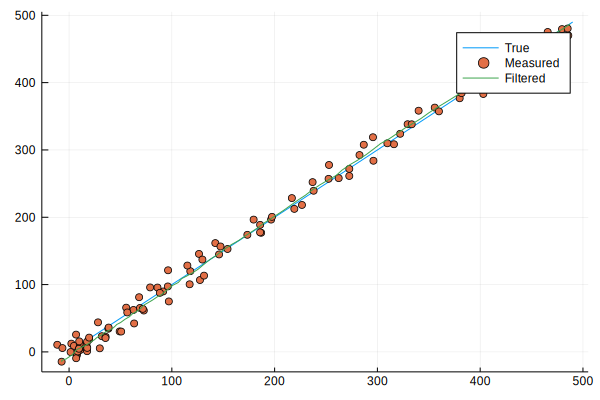

In [403]:
xf,kGains = runKalmanKinematic(measurements,dt,ax,ay,noise,vnoise)
plot!(xf[1,:],xf[2,:],label="Filtered")

RMSE error of filtered values. X, Y, Vx, Vy in order

In [404]:
sqrt.(sum((xf - transpose(measurements)).^2,dims=2)/100)

4×1 Array{Float64,2}:
 9.280421394014295  
 9.650887726667014  
 0.4108387813603714 
 0.37180957496588624